In [142]:
!pip3 install scikit-learn tqdm catboost optuna xgboost ipywidgets imblearn
# 모델을 위해 필요한 라이브러리 설치(우수 예시에만 있는 부분)

In [143]:
import pandas as pd
import sklearn
import numpy as np
import random
import os
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')


In [144]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed=42
seed_everything(seed) # Seed 고정

In [145]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [146]:
def category_all(df_train, df_test):
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    'customer_idx',
    'lead_owner',
    ]
    for i in label_columns:
        df_train[i] = df_train[i].astype('category')
        df_test[i] = df_test[i].astype('category')
    return df_train, df_test    


def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""
    
    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

        
def manage_label_encoding(df_train, df_test):
    tmp = len(df_train)
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    'customer_idx',
    'lead_owner',
    ]
    
    df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

    for col in label_columns:
        df_all[col] = label_encoding(df_all[col])
    
    for col in label_columns:  
        df_train[col] = df_all.iloc[: tmp][col]
        df_test[col] = df_all.iloc[tmp :][col]

    return df_train, df_test

def preprocessing(df_train, df_test):
    df_train.drop_duplicates(keep='first', inplace=True)
    df_train.reset_index(inplace=True)
    df_train.drop('index',inplace=True, axis=1)
    df_test_id_temp = df_test['id'].copy()
    df_all = pd.concat([df_train,df_test.drop('id',axis=1)])
    df_all.drop('customer_country.1',axis=1,inplace=True)
    df_all.id_strategic_ver.fillna(0., inplace=True)
    df_all.it_strategic_ver.fillna(0., inplace=True)
    df_all.idit_strategic_ver.fillna(0., inplace=True)
    df_all.business_subarea.fillna('NAN', inplace=True)
    df_all.com_reg_ver_win_rate.fillna(0,inplace=True)
    df_all['customer_type'] = df_all['customer_type'].replace({
        'End-Customer':'End Customer'
    })
    df_all.customer_type.fillna('NAN',inplace=True)
    df_all.historical_existing_cnt.fillna(0, inplace=True)
    
    df_all.product_subcategory.fillna('NAN', inplace=True)
    
    df_all.product_modelname.fillna('NAN', inplace=True)

    df_all['expected_timeline'] = df_all['expected_timeline'].replace({
        'less_than_3_months': 'less than 3 months',  # merge into 'less than 3 months'
        'being followed up': 'being followed up.',  # merge into 'being followed up.'
        'less than 6 months': '3 months ~ 6 months',  # merge into '3 months ~ 6 months'
        '3_months_~_6_months' : '3 months ~ 6 months'
    })

    df_all.expected_timeline.fillna('NAN',inplace=True)
    df_all.ver_win_rate_x.fillna(0,inplace=True)
    df_all.ver_win_ratio_per_bu.fillna(0,inplace=True)
    df_all.business_area.fillna('NAN',inplace=True)
    df_all.customer_job.fillna('NAN', inplace=True)
    df_all.product_category.fillna('NAN', inplace=True)
    
    #처리못한부분
    #customer_country
    df_all.customer_country.fillna('NAN', inplace=True)
    #inquiry_type
    df_all.inquiry_type.fillna('NAN', inplace=True)

    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    ]
    
    for i in label_columns:
        df_all[i] = df_all[i].str.lower()
        df_all[i] = df_all[i].str.replace(pat=r'[^\w]', repl=r'', regex=True)
        
    tmp_len = len(df_train)
    df_train = df_all.iloc[: tmp_len ]
    df_test = df_all.iloc[tmp_len :]
    df_test = pd.concat([df_test,df_test_id_temp],axis=1)
    return df_train, df_test
df_train, df_test = preprocessing(df_train, df_test)
df_train, df_test = category_all(df_train, df_test)

In [147]:
rate = ((len(df_train)-sum(df_train['is_converted']))/sum(df_train['is_converted']))
def custom_split(df_train, num=5, idx=0, smote=False, false_rate=1):
    global rate

    #shuffle
    true_df_train = sklearn.utils.shuffle(df_train[df_train["is_converted"]==True], random_state=seed)
    false_df_train = sklearn.utils.shuffle(df_train[df_train["is_converted"]==False], random_state=seed)
    
    #k-fold num
    slice_num = len(true_df_train) // num
    
    #True:False = 1:1
    tmp_train = pd.concat([true_df_train[0:slice_num*idx],
                           true_df_train[slice_num*(idx+1):],
                           false_df_train[0:int((slice_num*false_rate)*idx)],
                           false_df_train[int((slice_num*false_rate)*(idx+1)):]])
    tmp_val = pd.concat([true_df_train[slice_num*idx:slice_num*(idx+1)],
                         false_df_train[int((slice_num*false_rate)*idx):int((slice_num*false_rate)*(idx+1))]])
    #shuffle
    tmp_train = sklearn.utils.shuffle(tmp_train, random_state=seed)
    tmp_val = sklearn.utils.shuffle(tmp_val, random_state=seed)

    #split x and y
    x_train, y_train = tmp_train.drop("is_converted",axis=1), tmp_train["is_converted"]
    x_val, y_val = tmp_val.drop("is_converted",axis=1), tmp_val["is_converted"]
    
    if(smote):
        sm = BorderlineSMOTE(random_state=seed)
        x_train, y_train = sm.fit_resample(x_train, y_train)
    categorical_features = label_columns = [
                                            "customer_country",
                                            "business_subarea",
                                            "business_area",
                                            "business_unit",
                                            "customer_type",
                                            "enterprise",
                                            "customer_job",
                                            "inquiry_type",
                                            "product_category",
                                            "product_subcategory",
                                            "product_modelname",
                                            "customer_position",
                                            "response_corporate",
                                            "expected_timeline",
                                            'customer_idx',
                                            'lead_owner',
                                        ]
    train_pool = Pool(data=x_train, label=y_train, cat_features=categorical_features)
    val_pool = Pool(data=x_val, label=y_val, cat_features=categorical_features)

    return train_pool, val_pool, list(y_val)


# all_x_trains = []
# all_y_trains = []
# all_x_vals = []
# all_y_vals = []
# k_fold_num = 5
# for idx in range(k_fold_num):
#     bundle = custom_split(df_train, num=k_fold_num, idx=idx, smote=False, false_rate=rate)
#     all_x_trains.append(bundle[0])
#     all_y_trains.append(bundle[1])
#     all_x_vals.append(bundle[2])
#     all_y_vals.append(bundle[3])

all_train_pool = []
all_val_pool = []
all_y_val = []
k_fold_num = 10
for idx in range(k_fold_num):
    bundle = custom_split(df_train, num=k_fold_num, idx=idx, smote=False, false_rate=rate)
    all_train_pool.append(bundle[0])
    all_val_pool.append(bundle[1])
    all_y_val.append(bundle[2])

In [ ]:
def objective(trial):
    params = {
        'iterations':trial.suggest_int("iterations", 1000, 30000),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.001, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-8,100),
        'random_strength': trial.suggest_uniform('random_strength',0,100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,100),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'verbose':False,
        'random_state':seed,
    }
    
    score = []
    tmp_score = []
    for train_pool, val_pool, y_true in zip(all_train_pool, all_val_pool, all_y_val):
        clf = CatBoostClassifier(**params,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                 task_type="GPU",
                                 devices='0',
                                early_stopping_rounds=50, 
                                )
        clf.fit(train_pool, eval_set=val_pool)
        
        y_pred = clf.predict(val_pool)
        y_pred = [False if i=='False' else True for i in y_pred]
        tmp_score.append(f1_score(y_true,y_pred,labels=[True, False]))
        score.append((f1_score(y_true,y_pred,labels=[True, False])+recall_score(y_true,y_pred))/2)
    score = np.mean(score)
    print(np.mean(tmp_score))
    return score

# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed), pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=None)

[I 2024-02-09 15:38:22,978] A new study created in memory with name: no-name-603330b7-4c91-4398-8b42-482ed1365da6
[I 2024-02-09 15:38:38,892] Trial 0 finished with value: 0.8509847693725512 and parameters: {'iterations': 11862, 'learning_rate': 0.9507635921035062, 'reg_lambda': 73.1993968612011, 'random_strength': 33.946339367881464, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.017073967431528128}. Best is trial 0 with value: 0.8509847693725512.


0.7567314435070068


[I 2024-02-09 15:38:56,126] Trial 1 finished with value: 0.8562838509290234 and parameters: {'iterations': 26119, 'learning_rate': 0.6015138967314656, 'reg_lambda': 70.80726069887878, 'random_strength': 10.823379771832098, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.07068974950624607}. Best is trial 1 with value: 0.8562838509290234.


0.7649486542389994


[I 2024-02-09 15:39:16,624] Trial 2 finished with value: 0.8368310596385236 and parameters: {'iterations': 6273, 'learning_rate': 0.18422110534358038, 'reg_lambda': 30.424231253531342, 'random_strength': 30.990257265289515, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 5, 'bagging_temperature': 2.801635158716261}. Best is trial 1 with value: 0.8562838509290234.


0.722579868194796


[I 2024-02-09 15:39:37,154] Trial 3 finished with value: 0.8543602813883127 and parameters: {'iterations': 5045, 'learning_rate': 0.29285250388668294, 'reg_lambda': 36.63619066575074, 'random_strength': 28.24279936868144, 'min_data_in_leaf': 24, 'leaf_estimation_iterations': 3, 'bagging_temperature': 1.1400863701127328}. Best is trial 1 with value: 0.8562838509290234.


0.7580712121272744


[I 2024-02-09 15:39:44,640] Trial 4 finished with value: 0.7109518671966885 and parameters: {'iterations': 18180, 'learning_rate': 0.047403962307277725, 'reg_lambda': 60.75448911469532, 'random_strength': 16.82096494749166, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 15, 'bagging_temperature': 72.86653737491046}. Best is trial 1 with value: 0.8562838509290234.


0.7584838209734636


[I 2024-02-09 15:40:02,384] Trial 5 finished with value: 0.8540153942879734 and parameters: {'iterations': 24444, 'learning_rate': 0.30530915540419734, 'reg_lambda': 9.767220423917246, 'random_strength': 37.36932106048627, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 2, 'bagging_temperature': 0.9565499215943827}. Best is trial 1 with value: 0.8562838509290234.


0.7588965894417473


[I 2024-02-09 15:40:15,999] Trial 6 finished with value: 0.8430274098085123 and parameters: {'iterations': 1997, 'learning_rate': 0.9094110816767033, 'reg_lambda': 25.878005572201875, 'random_strength': 36.50089137415928, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 8, 'bagging_temperature': 1.5375920235481764}. Best is trial 1 with value: 0.8562838509290234.


0.7434141269763319


[I 2024-02-09 15:40:23,235] Trial 7 finished with value: 0.7109518671966885 and parameters: {'iterations': 6360, 'learning_rate': 0.969615043136794, 'reg_lambda': 77.51328458478322, 'random_strength': 47.579957662567566, 'min_data_in_leaf': 27, 'leaf_estimation_iterations': 9, 'bagging_temperature': 48.696409415209004}. Best is trial 1 with value: 0.8562838509290234.


0.7584838209734636


[I 2024-02-09 15:40:51,648] Trial 8 finished with value: 0.7478478420410749 and parameters: {'iterations': 3566, 'learning_rate': 0.19678687955672605, 'reg_lambda': 4.522738438780917, 'random_strength': 23.013213230530575, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 5, 'bagging_temperature': 20.651425578959262}. Best is trial 1 with value: 0.8562838509290234.


0.5905008788873446


[I 2024-02-09 15:40:58,333] Trial 9 finished with value: 0.7109518671966885 and parameters: {'iterations': 11346, 'learning_rate': 0.2816535751776934, 'reg_lambda': 54.26961288886402, 'random_strength': 15.636968998990506, 'min_data_in_leaf': 25, 'leaf_estimation_iterations': 2, 'bagging_temperature': 88.62326508576255}. Best is trial 1 with value: 0.8562838509290234.


0.7584838209734636


[I 2024-02-09 15:41:16,670] Trial 10 finished with value: 0.8578770522808219 and parameters: {'iterations': 29387, 'learning_rate': 0.6556785267510751, 'reg_lambda': 96.95371138341545, 'random_strength': 10.718475024592777, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.021064468501944014}. Best is trial 10 with value: 0.8578770522808219.


0.7685679573754964


[I 2024-02-09 15:41:36,363] Trial 11 finished with value: 0.856068784191651 and parameters: {'iterations': 29432, 'learning_rate': 0.6272567612616611, 'reg_lambda': 99.74654750194215, 'random_strength': 10.349894678744427, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.01875348045209675}. Best is trial 10 with value: 0.8578770522808219.


0.7668994731452068


[I 2024-02-09 15:41:52,156] Trial 12 finished with value: 0.8546275204994329 and parameters: {'iterations': 29820, 'learning_rate': 0.6277679970235266, 'reg_lambda': 99.45420878333931, 'random_strength': 10.173849113916495, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.09470314305954813}. Best is trial 10 with value: 0.8578770522808219.


0.7603372920811169


[I 2024-02-09 15:42:07,487] Trial 13 finished with value: 0.8554423386659584 and parameters: {'iterations': 22947, 'learning_rate': 0.6923736143258277, 'reg_lambda': 80.97734160550169, 'random_strength': 20.45860578194779, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.08101324842116016}. Best is trial 10 with value: 0.8578770522808219.


0.7645643310115703


[I 2024-02-09 15:42:25,069] Trial 14 finished with value: 0.8565567702191619 and parameters: {'iterations': 24212, 'learning_rate': 0.4680293148649111, 'reg_lambda': 87.17031137051998, 'random_strength': 15.148398807859591, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.11516744025981103}. Best is trial 10 with value: 0.8578770522808219.


0.7585680858928694


[I 2024-02-09 15:42:43,747] Trial 15 finished with value: 0.860313000666617 and parameters: {'iterations': 19696, 'learning_rate': 0.4652169050427779, 'reg_lambda': 86.82216740797455, 'random_strength': 24.690613271433328, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.3081196928611647}. Best is trial 15 with value: 0.860313000666617.


0.7708424515496843


[I 2024-02-09 15:42:59,542] Trial 16 finished with value: 0.8566634898549064 and parameters: {'iterations': 19152, 'learning_rate': 0.7901757228428017, 'reg_lambda': 89.9432048093765, 'random_strength': 25.39796407337817, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.33120204481888305}. Best is trial 15 with value: 0.860313000666617.


0.7667901831730162


[I 2024-02-09 15:43:17,248] Trial 17 finished with value: 0.8580918296096032 and parameters: {'iterations': 20088, 'learning_rate': 0.49479551142000544, 'reg_lambda': 62.32555614183882, 'random_strength': 43.057391974389205, 'min_data_in_leaf': 23, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.010642849583807141}. Best is trial 15 with value: 0.860313000666617.


0.7646685077040548


[I 2024-02-09 15:43:40,084] Trial 18 finished with value: 0.8342775253656768 and parameters: {'iterations': 15057, 'learning_rate': 0.4482565868392485, 'reg_lambda': 62.93287030969486, 'random_strength': 44.38599500782205, 'min_data_in_leaf': 23, 'leaf_estimation_iterations': 7, 'bagging_temperature': 6.96404749361522}. Best is trial 15 with value: 0.860313000666617.


0.7289446611209639


[I 2024-02-09 15:43:58,642] Trial 19 finished with value: 0.86201133580536 and parameters: {'iterations': 20424, 'learning_rate': 0.43676996486599806, 'reg_lambda': 44.48243597755015, 'random_strength': 42.242222901052266, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.23891278761612442}. Best is trial 19 with value: 0.86201133580536.


0.7746720222600707


[I 2024-02-09 15:44:16,648] Trial 20 finished with value: 0.8598973033604768 and parameters: {'iterations': 15921, 'learning_rate': 0.4033731029307742, 'reg_lambda': 42.63467234594273, 'random_strength': 41.83471047574292, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.4212805954213886}. Best is trial 19 with value: 0.86201133580536.


0.7687123556387027


[I 2024-02-09 15:44:35,837] Trial 21 finished with value: 0.86114062659289 and parameters: {'iterations': 15485, 'learning_rate': 0.41670800705932637, 'reg_lambda': 41.88233399090721, 'random_strength': 40.60643470918523, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.40166588831185296}. Best is trial 19 with value: 0.86201133580536.


0.7722812531857802


[I 2024-02-09 15:44:53,883] Trial 22 finished with value: 0.8603274023065562 and parameters: {'iterations': 12929, 'learning_rate': 0.36008784500570157, 'reg_lambda': 44.70128717223871, 'random_strength': 49.074415224238884, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.2717196670611209}. Best is trial 19 with value: 0.86201133580536.


0.7676245015828098


[I 2024-02-09 15:45:10,383] Trial 23 finished with value: 0.8571434096724928 and parameters: {'iterations': 10511, 'learning_rate': 0.3728992090507133, 'reg_lambda': 47.23267881513165, 'random_strength': 49.966379791859, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.18297731147216983}. Best is trial 19 with value: 0.86201133580536.


0.7625552176133841


[I 2024-02-09 15:45:35,250] Trial 24 finished with value: 0.8567137829105308 and parameters: {'iterations': 14483, 'learning_rate': 0.15819482805239365, 'reg_lambda': 21.703903858770165, 'random_strength': 41.210515403683, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.5675601671117025}. Best is trial 19 with value: 0.86201133580536.


0.761046613440109


[I 2024-02-09 15:45:52,030] Trial 25 finished with value: 0.8612125990384808 and parameters: {'iterations': 8405, 'learning_rate': 0.5435860247194085, 'reg_lambda': 39.15124199091863, 'random_strength': 45.60180476504924, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.05215548108761348}. Best is trial 19 with value: 0.86201133580536.


0.7719922976440612


[I 2024-02-09 15:46:08,188] Trial 26 finished with value: 0.8570327819137697 and parameters: {'iterations': 9144, 'learning_rate': 0.516849934680035, 'reg_lambda': 19.337147341021957, 'random_strength': 38.719758344973755, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.04543333427377922}. Best is trial 19 with value: 0.86201133580536.


0.7651478149097904


[I 2024-02-09 15:46:23,710] Trial 27 finished with value: 0.8335074371767593 and parameters: {'iterations': 8651, 'learning_rate': 0.5430350475202002, 'reg_lambda': 35.57484371335234, 'random_strength': 45.79009223944608, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 8, 'bagging_temperature': 3.4359906257426283}. Best is trial 19 with value: 0.86201133580536.


0.7269715843102285


[I 2024-02-09 15:46:38,965] Trial 28 finished with value: 0.8545930725617399 and parameters: {'iterations': 16940, 'learning_rate': 0.7654141062058272, 'reg_lambda': 52.46471307516905, 'random_strength': 33.796130700854306, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 4, 'bagging_temperature': 0.04662411144828667}. Best is trial 19 with value: 0.86201133580536.


0.7626493485866832


[I 2024-02-09 15:46:56,502] Trial 29 finished with value: 0.8605462460330212 and parameters: {'iterations': 22591, 'learning_rate': 0.5604512078175905, 'reg_lambda': 40.166340913061134, 'random_strength': 39.97908139660786, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.16091788014496872}. Best is trial 19 with value: 0.86201133580536.


0.770659591633142


[I 2024-02-09 15:47:09,690] Trial 30 finished with value: 0.8551114701324586 and parameters: {'iterations': 20868, 'learning_rate': 0.7663355735748913, 'reg_lambda': 14.893377225070402, 'random_strength': 34.49579982513711, 'min_data_in_leaf': 9, 'leaf_estimation_iterations': 1, 'bagging_temperature': 0.02592810775046536}. Best is trial 19 with value: 0.86201133580536.


0.7591406891826663


[I 2024-02-09 15:47:25,945] Trial 31 finished with value: 0.8567739405264408 and parameters: {'iterations': 22610, 'learning_rate': 0.5601813979139314, 'reg_lambda': 38.782506012420946, 'random_strength': 40.05792853229901, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.12767176939826289}. Best is trial 19 with value: 0.86201133580536.


0.7696084871134875


[I 2024-02-09 15:47:42,911] Trial 32 finished with value: 0.8580110790086397 and parameters: {'iterations': 17940, 'learning_rate': 0.41644308645674705, 'reg_lambda': 32.63263894075575, 'random_strength': 46.033194607255986, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.6272970468465784}. Best is trial 19 with value: 0.86201133580536.


0.7647234567185783


[I 2024-02-09 15:47:58,342] Trial 33 finished with value: 0.8555981683221333 and parameters: {'iterations': 26375, 'learning_rate': 0.7125190319042825, 'reg_lambda': 26.44696726512291, 'random_strength': 32.52921232457396, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.051292786142209126}. Best is trial 19 with value: 0.86201133580536.


0.7627114881594178


[I 2024-02-09 15:48:14,153] Trial 34 finished with value: 0.8610038082397283 and parameters: {'iterations': 13571, 'learning_rate': 0.567584006983469, 'reg_lambda': 51.58787010791949, 'random_strength': 43.71732128560975, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.14395427859334123}. Best is trial 19 with value: 0.86201133580536.


0.7691937636656038


[I 2024-02-09 15:48:35,352] Trial 35 finished with value: 0.8605988151258142 and parameters: {'iterations': 8379, 'learning_rate': 0.33922429214697336, 'reg_lambda': 55.47845873398593, 'random_strength': 43.607062533279766, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 4, 'bagging_temperature': 0.19015646140053455}. Best is trial 19 with value: 0.86201133580536.


0.7690331280871261


[I 2024-02-09 15:48:55,275] Trial 36 finished with value: 0.8473330420120485 and parameters: {'iterations': 13113, 'learning_rate': 0.2500150157245126, 'reg_lambda': 68.85017115159613, 'random_strength': 29.34321918890358, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 6, 'bagging_temperature': 1.8710374782189598}. Best is trial 19 with value: 0.86201133580536.


0.7425015818595948


[I 2024-02-09 15:49:09,843] Trial 37 finished with value: 0.8526804688729694 and parameters: {'iterations': 13114, 'learning_rate': 0.5897901184912163, 'reg_lambda': 49.184514965258856, 'random_strength': 36.994728232046306, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 4, 'bagging_temperature': 0.7189774950682674}. Best is trial 19 with value: 0.86201133580536.


0.7568760892610905


[I 2024-02-09 15:49:48,571] Trial 38 finished with value: 0.845778567081581 and parameters: {'iterations': 6708, 'learning_rate': 0.04762286707257968, 'reg_lambda': 30.97101439426833, 'random_strength': 46.45235982327833, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.03403412669983292}. Best is trial 19 with value: 0.86201133580536.


0.7383103809164088


[I 2024-02-09 15:50:05,336] Trial 39 finished with value: 0.8559381424281801 and parameters: {'iterations': 16551, 'learning_rate': 0.42752383678681144, 'reg_lambda': 68.62961110289297, 'random_strength': 47.59140903064892, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.06957028952385758}. Best is trial 19 with value: 0.86201133580536.


0.7625256355057111


[I 2024-02-09 15:50:22,704] Trial 40 finished with value: 0.8562871938241369 and parameters: {'iterations': 10351, 'learning_rate': 0.5131015962892607, 'reg_lambda': 59.29037601913693, 'random_strength': 35.38004216334931, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 5, 'bagging_temperature': 1.0236117976077848}. Best is trial 19 with value: 0.86201133580536.


0.7653882404621267


[I 2024-02-09 15:50:43,767] Trial 41 finished with value: 0.8599689159048187 and parameters: {'iterations': 8333, 'learning_rate': 0.3509790159905598, 'reg_lambda': 55.81683554852036, 'random_strength': 43.74288072269662, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 4, 'bagging_temperature': 0.23218001061240728}. Best is trial 19 with value: 0.86201133580536.


0.7708036326754384


[I 2024-02-09 15:51:02,822] Trial 42 finished with value: 0.8601990412301281 and parameters: {'iterations': 4691, 'learning_rate': 0.3114134140098726, 'reg_lambda': 48.567221347151815, 'random_strength': 42.43140646820255, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.16935945250115608}. Best is trial 19 with value: 0.86201133580536.


0.7673677794299535


[I 2024-02-09 15:51:26,518] Trial 43 finished with value: 0.8570606161350739 and parameters: {'iterations': 1899, 'learning_rate': 0.2269779377849533, 'reg_lambda': 44.25158029970885, 'random_strength': 38.795487587307846, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 2, 'bagging_temperature': 0.44556388176245953}. Best is trial 19 with value: 0.86201133580536.


0.7604415785904939


[I 2024-02-09 15:51:39,480] Trial 44 finished with value: 0.8505748003184099 and parameters: {'iterations': 7161, 'learning_rate': 0.8734913307935002, 'reg_lambda': 57.655713602665514, 'random_strength': 44.433989233632346, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.06179278513986682}. Best is trial 19 with value: 0.86201133580536.


0.7511496006368199


[I 2024-02-09 15:52:12,854] Trial 45 finished with value: 0.855283193552317 and parameters: {'iterations': 11831, 'learning_rate': 0.1070679388255461, 'reg_lambda': 35.08675653876543, 'random_strength': 48.47608086173177, 'min_data_in_leaf': 21, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.10209791410679334}. Best is trial 19 with value: 0.86201133580536.


0.7547222312604781


[I 2024-02-09 15:52:33,367] Trial 46 finished with value: 0.8576470867931894 and parameters: {'iterations': 14215, 'learning_rate': 0.3357962429756939, 'reg_lambda': 53.16229081851701, 'random_strength': 45.3880575424289, 'min_data_in_leaf': 28, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.19515828877650465}. Best is trial 19 with value: 0.86201133580536.


0.7646448229370282


[I 2024-02-09 15:52:53,046] Trial 47 finished with value: 0.853788097045032 and parameters: {'iterations': 4673, 'learning_rate': 0.3928616376828451, 'reg_lambda': 28.45755006733189, 'random_strength': 38.361646076165236, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 4, 'bagging_temperature': 1.4657571894394748}. Best is trial 19 with value: 0.86201133580536.


0.7606064971203674


[I 2024-02-09 15:53:08,057] Trial 48 finished with value: 0.8578500062399648 and parameters: {'iterations': 10207, 'learning_rate': 0.6635881486317279, 'reg_lambda': 41.094963277437174, 'random_strength': 40.65375939803314, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.13174377429828577}. Best is trial 19 with value: 0.86201133580536.


0.7669987137786313


[I 2024-02-09 15:53:24,952] Trial 49 finished with value: 0.8604371664789665 and parameters: {'iterations': 7471, 'learning_rate': 0.5884111538388204, 'reg_lambda': 64.56617926094931, 'random_strength': 31.396301423579423, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.032080301541766665}. Best is trial 19 with value: 0.86201133580536.


0.7684933805769808


[I 2024-02-09 15:53:41,575] Trial 50 finished with value: 0.857415310970578 and parameters: {'iterations': 17491, 'learning_rate': 0.4925586646398884, 'reg_lambda': 50.209368571388595, 'random_strength': 47.36189366790378, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.01146047247855198}. Best is trial 19 with value: 0.86201133580536.


0.7643977215082554


[I 2024-02-09 15:54:00,831] Trial 51 finished with value: 0.8643536902427801 and parameters: {'iterations': 23917, 'learning_rate': 0.551172502066262, 'reg_lambda': 40.66947761897298, 'random_strength': 40.263008969210304, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.1521370190096596}. Best is trial 51 with value: 0.8643536902427801.


0.7795731813513609


[I 2024-02-09 15:54:17,601] Trial 52 finished with value: 0.8549409596241387 and parameters: {'iterations': 25533, 'learning_rate': 0.4562564027038704, 'reg_lambda': 35.37173675327249, 'random_strength': 42.78616594374451, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.37323685253706335}. Best is trial 51 with value: 0.8643536902427801.


0.760964170330529


[I 2024-02-09 15:54:36,095] Trial 53 finished with value: 0.8610966796786853 and parameters: {'iterations': 21009, 'learning_rate': 0.5232222311776417, 'reg_lambda': 75.04410064171404, 'random_strength': 41.673176956396105, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.09128329153735461}. Best is trial 51 with value: 0.8643536902427801.


0.7695959567599677


[I 2024-02-09 15:54:52,189] Trial 54 finished with value: 0.8574305859270668 and parameters: {'iterations': 21179, 'learning_rate': 0.6232698323061142, 'reg_lambda': 73.19977401383153, 'random_strength': 41.41100258516048, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.08589877863654112}. Best is trial 51 with value: 0.8643536902427801.


0.7657269727199346


[I 2024-02-09 15:55:11,307] Trial 55 finished with value: 0.8613695231622032 and parameters: {'iterations': 18954, 'learning_rate': 0.536682873430887, 'reg_lambda': 80.00920581283482, 'random_strength': 35.92810334037722, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.2813712771850605}. Best is trial 51 with value: 0.8643536902427801.


0.7723061458915059


[I 2024-02-09 15:55:28,933] Trial 56 finished with value: 0.8585887183818771 and parameters: {'iterations': 18457, 'learning_rate': 0.531807935993409, 'reg_lambda': 93.81268327372968, 'random_strength': 37.36412273298447, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.26945549035711536}. Best is trial 51 with value: 0.8643536902427801.


0.7654458350321527


[I 2024-02-09 15:55:45,860] Trial 57 finished with value: 0.854883174363122 and parameters: {'iterations': 24232, 'learning_rate': 0.4802760956306756, 'reg_lambda': 74.07033264030397, 'random_strength': 35.88019258804181, 'min_data_in_leaf': 9, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.4598213253310498}. Best is trial 51 with value: 0.8643536902427801.


0.7610650500249452


[I 2024-02-09 15:56:01,759] Trial 58 finished with value: 0.8562177906625573 and parameters: {'iterations': 28212, 'learning_rate': 0.6623357080137604, 'reg_lambda': 82.09973050334281, 'random_strength': 39.377953510120776, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.8847453343349891}. Best is trial 51 with value: 0.8643536902427801.


0.7639507328402662


[I 2024-02-09 15:56:20,173] Trial 59 finished with value: 0.8592672556842007 and parameters: {'iterations': 21246, 'learning_rate': 0.42734952711868895, 'reg_lambda': 82.93526216715983, 'random_strength': 41.50939571608779, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.09350198719642151}. Best is trial 51 with value: 0.8643536902427801.


0.7674522602861502


[I 2024-02-09 15:56:46,081] Trial 60 finished with value: 0.7721169726197655 and parameters: {'iterations': 19618, 'learning_rate': 0.6184527627761742, 'reg_lambda': 78.5291013974782, 'random_strength': 38.02056570125122, 'min_data_in_leaf': 11, 'leaf_estimation_iterations': 13, 'bagging_temperature': 38.40259892013036}. Best is trial 51 with value: 0.8643536902427801.


0.6444503954559815


[I 2024-02-09 15:57:02,749] Trial 61 finished with value: 0.8594714326139279 and parameters: {'iterations': 22099, 'learning_rate': 0.5743984968422503, 'reg_lambda': 45.03476518539599, 'random_strength': 44.719366016229614, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.13970826323584856}. Best is trial 51 with value: 0.8643536902427801.


0.7663454626304534


[I 2024-02-09 15:57:19,708] Trial 62 finished with value: 0.8593622087755561 and parameters: {'iterations': 15694, 'learning_rate': 0.5263730394737768, 'reg_lambda': 37.600560254598506, 'random_strength': 42.23808907836741, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.2587868745671636}. Best is trial 51 with value: 0.8643536902427801.


0.7706724694991643


[I 2024-02-09 15:57:34,492] Trial 63 finished with value: 0.8564564017385718 and parameters: {'iterations': 23269, 'learning_rate': 0.7118600046764672, 'reg_lambda': 41.50209256505002, 'random_strength': 40.76071680420862, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.060748609354423104}. Best is trial 51 with value: 0.8643536902427801.


0.7637786043429443


[I 2024-02-09 15:57:51,412] Trial 64 finished with value: 0.8597393098619944 and parameters: {'iterations': 19182, 'learning_rate': 0.45475670947651836, 'reg_lambda': 24.245204070550866, 'random_strength': 43.48405797658368, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.3409227883330895}. Best is trial 51 with value: 0.8643536902427801.


0.7718595721049412


[I 2024-02-09 15:58:08,590] Trial 65 finished with value: 0.8572950741798586 and parameters: {'iterations': 20390, 'learning_rate': 0.5529402356390993, 'reg_lambda': 93.0713808950518, 'random_strength': 46.794975875397, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.5353134166509749}. Best is trial 51 with value: 0.8643536902427801.


0.7661052998748684


[I 2024-02-09 15:58:26,735] Trial 66 finished with value: 0.8595129830478323 and parameters: {'iterations': 25294, 'learning_rate': 0.49190676710839837, 'reg_lambda': 65.23003102695684, 'random_strength': 33.65384543078952, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.03360646647386006}. Best is trial 51 with value: 0.8643536902427801.


0.7690259660956643


[I 2024-02-09 15:58:48,005] Trial 67 finished with value: 0.861465253211837 and parameters: {'iterations': 16850, 'learning_rate': 0.3772425665449332, 'reg_lambda': 86.49942848700603, 'random_strength': 45.11254482948321, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.11347278471024547}. Best is trial 51 with value: 0.8643536902427801.


0.7720647055578735


[I 2024-02-09 15:59:08,210] Trial 68 finished with value: 0.8591218334320734 and parameters: {'iterations': 18384, 'learning_rate': 0.39108392733119124, 'reg_lambda': 88.60067279532434, 'random_strength': 39.3902013846887, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.07668072418255016}. Best is trial 51 with value: 0.8643536902427801.


0.7673778659983461


[I 2024-02-09 15:59:32,529] Trial 69 finished with value: 0.8585853764236626 and parameters: {'iterations': 3004, 'learning_rate': 0.26626854761286495, 'reg_lambda': 75.9991201818579, 'random_strength': 48.68121264716964, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.10961160653449922}. Best is trial 51 with value: 0.8643536902427801.


0.7673872030637756


[I 2024-02-09 15:59:50,714] Trial 70 finished with value: 0.853912781406066 and parameters: {'iterations': 23477, 'learning_rate': 0.29988798970934816, 'reg_lambda': 84.58179932494258, 'random_strength': 12.69607206491225, 'min_data_in_leaf': 21, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.016723745194803533}. Best is trial 51 with value: 0.8643536902427801.


0.753713008699578


[I 2024-02-09 16:00:08,264] Trial 71 finished with value: 0.8586881584118021 and parameters: {'iterations': 17069, 'learning_rate': 0.4331492261787411, 'reg_lambda': 46.68835853021324, 'random_strength': 45.523274849048285, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.20134701362664317}. Best is trial 51 with value: 0.8643536902427801.


0.7695408189881066


[I 2024-02-09 16:00:24,472] Trial 72 finished with value: 0.8592916815395835 and parameters: {'iterations': 14732, 'learning_rate': 0.5050967144621257, 'reg_lambda': 31.512289616671584, 'random_strength': 27.356772975592293, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.1489796118916008}. Best is trial 51 with value: 0.8643536902427801.


0.7709643154601193


[I 2024-02-09 16:00:42,837] Trial 73 finished with value: 0.8610274833382547 and parameters: {'iterations': 21746, 'learning_rate': 0.5433163024866012, 'reg_lambda': 51.00886739626213, 'random_strength': 49.916131640087144, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.04267164449066559}. Best is trial 51 with value: 0.8643536902427801.


0.7703233649449075


[I 2024-02-09 16:00:57,830] Trial 74 finished with value: 0.8562382180385407 and parameters: {'iterations': 21739, 'learning_rate': 0.6112585737530745, 'reg_lambda': 79.65562129364903, 'random_strength': 49.36110045372133, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.03775274819080296}. Best is trial 51 with value: 0.8643536902427801.


0.7590132326138781


[I 2024-02-09 16:01:16,569] Trial 75 finished with value: 0.8582879062141947 and parameters: {'iterations': 20327, 'learning_rate': 0.3779087606377147, 'reg_lambda': 38.610499779764154, 'random_strength': 48.26139093458257, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.022054986624517443}. Best is trial 51 with value: 0.8643536902427801.


0.7691732150257921


[I 2024-02-09 16:01:36,057] Trial 76 finished with value: 0.8613847899864927 and parameters: {'iterations': 16384, 'learning_rate': 0.46720638363678185, 'reg_lambda': 91.74011095378553, 'random_strength': 36.28332569320418, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.049902226385075146}. Best is trial 51 with value: 0.8643536902427801.


0.7703886275920331


[I 2024-02-09 16:01:56,447] Trial 77 finished with value: 0.8619917662367769 and parameters: {'iterations': 16350, 'learning_rate': 0.4739461949976853, 'reg_lambda': 91.17495778931612, 'random_strength': 34.50961967369189, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.051952389720516454}. Best is trial 51 with value: 0.8643536902427801.


0.7722519307419521


[I 2024-02-09 16:02:16,201] Trial 78 finished with value: 0.859778355134082 and parameters: {'iterations': 15739, 'learning_rate': 0.4732862134659336, 'reg_lambda': 92.80171054295684, 'random_strength': 35.21518096708317, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.06163472347233917}. Best is trial 51 with value: 0.8643536902427801.


0.7706389613504149


[I 2024-02-09 16:02:36,193] Trial 79 finished with value: 0.8579630944986236 and parameters: {'iterations': 16382, 'learning_rate': 0.41948742410854706, 'reg_lambda': 98.70490577690421, 'random_strength': 32.18125640381136, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.05147822848510071}. Best is trial 51 with value: 0.8643536902427801.


0.7659261889972473


[I 2024-02-09 16:02:58,276] Trial 80 finished with value: 0.8599847985404045 and parameters: {'iterations': 17643, 'learning_rate': 0.33108822176626423, 'reg_lambda': 87.4031987785874, 'random_strength': 36.94120373212197, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.017132872486143595}. Best is trial 51 with value: 0.8643536902427801.


0.7695366966479086


[I 2024-02-09 16:03:16,092] Trial 81 finished with value: 0.8555113177026359 and parameters: {'iterations': 19534, 'learning_rate': 0.5081110967555503, 'reg_lambda': 90.92423815469954, 'random_strength': 36.304749009734564, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.0804089897500228}. Best is trial 51 with value: 0.8643536902427801.


0.7610226354052716


[I 2024-02-09 16:03:34,854] Trial 82 finished with value: 0.8597599211288166 and parameters: {'iterations': 18842, 'learning_rate': 0.45611457522764803, 'reg_lambda': 95.11805353931379, 'random_strength': 33.35552466698177, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.10912322264963528}. Best is trial 51 with value: 0.8643536902427801.


0.7688704916082829


[I 2024-02-09 16:03:52,715] Trial 83 finished with value: 0.8570433429349187 and parameters: {'iterations': 26881, 'learning_rate': 0.3968407949022046, 'reg_lambda': 84.45786042864029, 'random_strength': 40.42169783571906, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.23451734895798815}. Best is trial 51 with value: 0.8643536902427801.


0.761922183705335


[I 2024-02-09 16:04:21,703] Trial 84 finished with value: 0.8347432578186273 and parameters: {'iterations': 15282, 'learning_rate': 0.36317310949079523, 'reg_lambda': 96.19797527992759, 'random_strength': 34.812377077598704, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 15, 'bagging_temperature': 7.338373746020319}. Best is trial 51 with value: 0.8643536902427801.


0.7270622732130121


[I 2024-02-09 16:04:39,416] Trial 85 finished with value: 0.8597256409254858 and parameters: {'iterations': 13782, 'learning_rate': 0.5912278428516737, 'reg_lambda': 85.15755180012518, 'random_strength': 37.77520114673487, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.027258978180660958}. Best is trial 51 with value: 0.8643536902427801.


0.7683690307687205


[I 2024-02-09 16:04:58,193] Trial 86 finished with value: 0.8597048729641742 and parameters: {'iterations': 12368, 'learning_rate': 0.44719617537738254, 'reg_lambda': 90.12234826098856, 'random_strength': 39.40250242862242, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.3145975517444653}. Best is trial 51 with value: 0.8643536902427801.


0.7696261961447983


[I 2024-02-09 16:05:11,457] Trial 87 finished with value: 0.8504167713313221 and parameters: {'iterations': 16639, 'learning_rate': 0.5326919504562393, 'reg_lambda': 0.011999034903766415, 'random_strength': 30.414929473660862, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.051412836630359775}. Best is trial 51 with value: 0.8643536902427801.


0.758842200671302


[I 2024-02-09 16:05:29,612] Trial 88 finished with value: 0.859857173517554 and parameters: {'iterations': 1155, 'learning_rate': 0.47254755839039775, 'reg_lambda': 42.82245998309841, 'random_strength': 44.628785811775394, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.2045041008387692}. Best is trial 51 with value: 0.8643536902427801.


0.7690649963857572


[I 2024-02-09 16:05:47,041] Trial 89 finished with value: 0.8540285996645928 and parameters: {'iterations': 18018, 'learning_rate': 0.40815184632189777, 'reg_lambda': 46.78105566547416, 'random_strength': 42.087727195119534, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.7770975659105729}. Best is trial 51 with value: 0.8643536902427801.


0.7613039525759389


[I 2024-02-09 16:06:03,318] Trial 90 finished with value: 0.8600184834904022 and parameters: {'iterations': 20008, 'learning_rate': 0.6385572943088015, 'reg_lambda': 34.21433201240517, 'random_strength': 36.311363198469806, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.10815162114510496}. Best is trial 51 with value: 0.8643536902427801.


0.7717685687124061


[I 2024-02-09 16:06:19,176] Trial 91 finished with value: 0.8573224439781132 and parameters: {'iterations': 22293, 'learning_rate': 0.544781898377045, 'reg_lambda': 75.10051176511756, 'random_strength': 46.77507914307807, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.04026834080330482}. Best is trial 51 with value: 0.8643536902427801.


0.761398134709473


[I 2024-02-09 16:06:37,471] Trial 92 finished with value: 0.8606103213613938 and parameters: {'iterations': 20893, 'learning_rate': 0.516609043153454, 'reg_lambda': 80.78828626934757, 'random_strength': 42.77874930251701, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.07360984895821997}. Best is trial 51 with value: 0.8643536902427801.


0.7699219414240861


[I 2024-02-09 16:06:53,822] Trial 93 finished with value: 0.8569719910605447 and parameters: {'iterations': 23912, 'learning_rate': 0.5611991846156805, 'reg_lambda': 40.40019406108235, 'random_strength': 19.366171684959745, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.044176278764813504}. Best is trial 51 with value: 0.8643536902427801.


0.7671907353678423


[I 2024-02-09 16:07:12,770] Trial 94 finished with value: 0.8607171759535721 and parameters: {'iterations': 18964, 'learning_rate': 0.48813156755258824, 'reg_lambda': 70.94747988595222, 'random_strength': 45.281328259169946, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.024888269177300065}. Best is trial 51 with value: 0.8643536902427801.


0.7705685510413435


[I 2024-02-09 16:07:29,539] Trial 95 finished with value: 0.8578881160722727 and parameters: {'iterations': 24860, 'learning_rate': 0.44019241972052114, 'reg_lambda': 28.61775377679676, 'random_strength': 43.93883514921801, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.1542082567647074}. Best is trial 51 with value: 0.8643536902427801.


0.7662091325774456


[I 2024-02-09 16:07:47,688] Trial 96 finished with value: 0.8598464747269615 and parameters: {'iterations': 5644, 'learning_rate': 0.5464222413585078, 'reg_lambda': 91.59799052816035, 'random_strength': 38.6755089798126, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.05685837071141823}. Best is trial 51 with value: 0.8643536902427801.


0.7681777979387714


[I 2024-02-09 16:08:03,921] Trial 97 finished with value: 0.8575409449627989 and parameters: {'iterations': 21662, 'learning_rate': 0.5829561447870455, 'reg_lambda': 77.54126953788564, 'random_strength': 49.87460348419731, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.09416428881067382}. Best is trial 51 with value: 0.8643536902427801.


0.7624844873281951


[I 2024-02-09 16:08:21,282] Trial 98 finished with value: 0.8548805725936799 and parameters: {'iterations': 17419, 'learning_rate': 0.37522141645773294, 'reg_lambda': 43.97931068294955, 'random_strength': 41.541021975309825, 'min_data_in_leaf': 9, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.12380145472948305}. Best is trial 51 with value: 0.8643536902427801.


0.7586788941051085


[I 2024-02-09 16:08:41,040] Trial 99 finished with value: 0.8586767844430577 and parameters: {'iterations': 15968, 'learning_rate': 0.47203334713381445, 'reg_lambda': 86.55908716204439, 'random_strength': 39.688664499371654, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.030421637396072797}. Best is trial 51 with value: 0.8643536902427801.


0.7680029195354661


[I 2024-02-09 16:08:56,306] Trial 100 finished with value: 0.8560504150598781 and parameters: {'iterations': 11138, 'learning_rate': 0.6012205493102374, 'reg_lambda': 13.426699462870921, 'random_strength': 47.598108641304115, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.5127121474119963}. Best is trial 51 with value: 0.8643536902427801.


0.7629666309855573


[I 2024-02-09 16:09:10,489] Trial 101 finished with value: 0.8568283159595966 and parameters: {'iterations': 14084, 'learning_rate': 0.6419148331472982, 'reg_lambda': 54.586899657735984, 'random_strength': 40.78093477746382, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.39238998712804213}. Best is trial 51 with value: 0.8643536902427801.


0.7638730821356433


[I 2024-02-09 16:09:25,362] Trial 102 finished with value: 0.8551952101296546 and parameters: {'iterations': 15206, 'learning_rate': 0.5673421473917071, 'reg_lambda': 37.70001653856305, 'random_strength': 43.848282471849785, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.16854952900777506}. Best is trial 51 with value: 0.8643536902427801.


0.7590917189606081


[I 2024-02-09 16:09:40,335] Trial 103 finished with value: 0.8560045791504745 and parameters: {'iterations': 13656, 'learning_rate': 0.5024364329067764, 'reg_lambda': 50.66879169687516, 'random_strength': 42.40633515540688, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.07028492571788747}. Best is trial 51 with value: 0.8643536902427801.


0.7607104570022476


[I 2024-02-09 16:09:57,470] Trial 104 finished with value: 0.8601634959282507 and parameters: {'iterations': 17180, 'learning_rate': 0.513867131943198, 'reg_lambda': 51.05531434253577, 'random_strength': 28.817417029800065, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.2960838654184808}. Best is trial 51 with value: 0.8643536902427801.


0.7690282905578002


[I 2024-02-09 16:10:14,355] Trial 105 finished with value: 0.8589694920305593 and parameters: {'iterations': 18497, 'learning_rate': 0.5300618633062, 'reg_lambda': 48.09381339152529, 'random_strength': 46.38408909825517, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.22010694559302427}. Best is trial 51 with value: 0.8643536902427801.


0.7668567329788676


[I 2024-02-09 16:10:29,459] Trial 106 finished with value: 0.8576323765519864 and parameters: {'iterations': 14513, 'learning_rate': 0.5685945946744311, 'reg_lambda': 59.879024139713266, 'random_strength': 43.14589154418843, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.01354036382464569}. Best is trial 51 with value: 0.8643536902427801.


0.7633167011559211


[I 2024-02-09 16:10:48,298] Trial 107 finished with value: 0.8625277190455097 and parameters: {'iterations': 22903, 'learning_rate': 0.42422577264657496, 'reg_lambda': 46.00250664133557, 'random_strength': 44.836713249121594, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.0887668166883155}. Best is trial 51 with value: 0.8643536902427801.


0.7744060874416688


[I 2024-02-09 16:11:07,034] Trial 108 finished with value: 0.8562928772854898 and parameters: {'iterations': 22981, 'learning_rate': 0.32003096663734343, 'reg_lambda': 33.405359001728, 'random_strength': 34.349424229565265, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.04317151441099342}. Best is trial 51 with value: 0.8643536902427801.


0.7632351052203301


[I 2024-02-09 16:11:24,277] Trial 109 finished with value: 0.8586971170679479 and parameters: {'iterations': 20684, 'learning_rate': 0.41189435217329934, 'reg_lambda': 39.77608687321894, 'random_strength': 45.17546800687715, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.0701708007384884}. Best is trial 51 with value: 0.8643536902427801.


0.7680435847852467


[I 2024-02-09 16:11:42,434] Trial 110 finished with value: 0.8602480344945738 and parameters: {'iterations': 21582, 'learning_rate': 0.4433841692248186, 'reg_lambda': 45.4721630619526, 'random_strength': 37.359283670658456, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.09344201563496145}. Best is trial 51 with value: 0.8643536902427801.


0.7713618698549485


[I 2024-02-09 16:11:59,439] Trial 111 finished with value: 0.8615612223868627 and parameters: {'iterations': 23555, 'learning_rate': 0.48476615214248103, 'reg_lambda': 42.147651775858215, 'random_strength': 44.382642971461514, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.1286222356243884}. Best is trial 51 with value: 0.8643536902427801.


0.7690098906611712


[I 2024-02-09 16:12:14,426] Trial 112 finished with value: 0.8549576989007163 and parameters: {'iterations': 23831, 'learning_rate': 0.4906966303166981, 'reg_lambda': 42.975425762574815, 'random_strength': 47.747324195090734, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.1207537434611697}. Best is trial 51 with value: 0.8643536902427801.


0.7588331467191812


[I 2024-02-09 16:12:31,712] Trial 113 finished with value: 0.8560937059803821 and parameters: {'iterations': 24645, 'learning_rate': 0.46123820212891, 'reg_lambda': 88.95766490598025, 'random_strength': 44.45166061767407, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.16938417665019834}. Best is trial 51 with value: 0.8643536902427801.


0.7619709617443141


[I 2024-02-09 16:12:50,442] Trial 114 finished with value: 0.8583649906796857 and parameters: {'iterations': 22577, 'learning_rate': 0.4256832720942813, 'reg_lambda': 36.705614299734286, 'random_strength': 46.22082296681038, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.057871245302210716}. Best is trial 51 with value: 0.8643536902427801.


0.7701931848225751


[I 2024-02-09 16:13:08,716] Trial 115 finished with value: 0.8598422573309531 and parameters: {'iterations': 26859, 'learning_rate': 0.3822685713045931, 'reg_lambda': 41.74192783772947, 'random_strength': 41.53371145703121, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.08514721756654287}. Best is trial 51 with value: 0.8643536902427801.


0.7696845146619059


[I 2024-02-09 16:13:26,629] Trial 116 finished with value: 0.8568916524875558 and parameters: {'iterations': 25515, 'learning_rate': 0.3509774958481373, 'reg_lambda': 46.44212987579843, 'random_strength': 35.65596565447329, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.13663538754178273}. Best is trial 51 with value: 0.8643536902427801.


0.7650820062738128


[I 2024-02-09 16:13:44,181] Trial 117 finished with value: 0.8595178330980986 and parameters: {'iterations': 19594, 'learning_rate': 0.479199643966744, 'reg_lambda': 48.314662613812416, 'random_strength': 32.994068338485945, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.24030718244756896}. Best is trial 51 with value: 0.8643536902427801.


0.7694685666290974


[I 2024-02-09 16:14:03,376] Trial 118 finished with value: 0.8581586845129868 and parameters: {'iterations': 23022, 'learning_rate': 0.40532621689762455, 'reg_lambda': 98.35537237741704, 'random_strength': 40.426973785545016, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.03829306881110548}. Best is trial 51 with value: 0.8643536902427801.


0.7650186677272721


[I 2024-02-09 16:14:18,311] Trial 119 finished with value: 0.8563193267413896 and parameters: {'iterations': 22045, 'learning_rate': 0.5358470652743349, 'reg_lambda': 39.196668996011695, 'random_strength': 38.62956381119091, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.0467606729285001}. Best is trial 51 with value: 0.8643536902427801.


0.7613399521840779


[I 2024-02-09 16:14:39,586] Trial 120 finished with value: 0.863226065245587 and parameters: {'iterations': 20097, 'learning_rate': 0.4404186364370247, 'reg_lambda': 81.81805935244051, 'random_strength': 43.23954395362238, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.10238419190275116}. Best is trial 51 with value: 0.8643536902427801.


0.7760192300582733


[I 2024-02-09 16:15:00,102] Trial 121 finished with value: 0.8592173706092222 and parameters: {'iterations': 20386, 'learning_rate': 0.4383200484356919, 'reg_lambda': 81.50646663343096, 'random_strength': 43.17293341743433, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.10812003262087708}. Best is trial 51 with value: 0.8643536902427801.


0.7693005420842453


[I 2024-02-09 16:15:21,098] Trial 122 finished with value: 0.8628338423847188 and parameters: {'iterations': 21317, 'learning_rate': 0.4640335057047758, 'reg_lambda': 83.66549051512847, 'random_strength': 42.59336249839867, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.08234192991079198}. Best is trial 51 with value: 0.8643536902427801.


0.7743689834707361


[I 2024-02-09 16:15:39,500] Trial 123 finished with value: 0.858421820818051 and parameters: {'iterations': 21193, 'learning_rate': 0.46302747762179064, 'reg_lambda': 86.55078800476144, 'random_strength': 42.50586299191965, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.08722612484753794}. Best is trial 51 with value: 0.8643536902427801.


0.7679258927183527


[I 2024-02-09 16:15:59,628] Trial 124 finished with value: 0.8587739916998742 and parameters: {'iterations': 19751, 'learning_rate': 0.4215103601384967, 'reg_lambda': 79.24394049800578, 'random_strength': 45.67972629401346, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.1305088711013362}. Best is trial 51 with value: 0.8643536902427801.


0.7679808838326487


[I 2024-02-09 16:16:16,409] Trial 125 finished with value: 0.857905065643973 and parameters: {'iterations': 16452, 'learning_rate': 0.5025872933687026, 'reg_lambda': 83.21247118153754, 'random_strength': 44.50863381654938, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.19307553420429793}. Best is trial 51 with value: 0.8643536902427801.


0.7640785295563444


[I 2024-02-09 16:16:35,316] Trial 126 finished with value: 0.8579033758681606 and parameters: {'iterations': 17988, 'learning_rate': 0.3969388437486491, 'reg_lambda': 94.60985853025069, 'random_strength': 31.467837088356458, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.063342600107935}. Best is trial 51 with value: 0.8643536902427801.


0.7642916002211693


[I 2024-02-09 16:16:54,177] Trial 127 finished with value: 0.8584000583682411 and parameters: {'iterations': 23594, 'learning_rate': 0.485938225473206, 'reg_lambda': 70.95576159857717, 'random_strength': 41.26152049758959, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.07611872459824023}. Best is trial 51 with value: 0.8643536902427801.


0.7663672163035817


[I 2024-02-09 16:17:11,970] Trial 128 finished with value: 0.8565561367587209 and parameters: {'iterations': 9557, 'learning_rate': 0.3606064071139271, 'reg_lambda': 76.772980275212, 'random_strength': 43.168831965728636, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.15540272146566883}. Best is trial 51 with value: 0.8643536902427801.


0.7620300224351907


[I 2024-02-09 16:17:29,219] Trial 129 finished with value: 0.8591331447366981 and parameters: {'iterations': 19043, 'learning_rate': 0.44841230381903663, 'reg_lambda': 84.08939657669212, 'random_strength': 42.02412713923754, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.2634988055559706}. Best is trial 51 with value: 0.8643536902427801.


0.7665346877417947


[I 2024-02-09 16:17:48,673] Trial 130 finished with value: 0.8606552194855788 and parameters: {'iterations': 20999, 'learning_rate': 0.5155557196938992, 'reg_lambda': 88.5931511680669, 'random_strength': 39.975288154632764, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.10092924396451733}. Best is trial 51 with value: 0.8643536902427801.


0.7719597896205082


[I 2024-02-09 16:18:05,996] Trial 131 finished with value: 0.8596585261626792 and parameters: {'iterations': 22707, 'learning_rate': 0.5442475939589069, 'reg_lambda': 91.6521088222228, 'random_strength': 43.92892449242733, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.03485768683613802}. Best is trial 51 with value: 0.8643536902427801.


0.7654209484292547


[I 2024-02-09 16:18:25,238] Trial 132 finished with value: 0.8602423740762433 and parameters: {'iterations': 22263, 'learning_rate': 0.47336397015292414, 'reg_lambda': 42.156703403970496, 'random_strength': 44.86590642976139, 'min_data_in_leaf': 3, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.055573032636265944}. Best is trial 51 with value: 0.8643536902427801.


0.77394795161569


[I 2024-02-09 16:18:40,621] Trial 133 finished with value: 0.8575648757435511 and parameters: {'iterations': 21658, 'learning_rate': 0.4996283221256108, 'reg_lambda': 80.97035342803419, 'random_strength': 45.78884150268417, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.3513417620722503}. Best is trial 51 with value: 0.8643536902427801.


0.7616665480238989


[I 2024-02-09 16:18:56,869] Trial 134 finished with value: 0.8608696621040599 and parameters: {'iterations': 24327, 'learning_rate': 0.5282320391909185, 'reg_lambda': 36.33807025464696, 'random_strength': 47.18662431768668, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.06767765885900212}. Best is trial 51 with value: 0.8643536902427801.


0.7708735233423186


[I 2024-02-09 16:19:13,080] Trial 135 finished with value: 0.8572221074874962 and parameters: {'iterations': 20258, 'learning_rate': 0.4332829518521537, 'reg_lambda': 57.50040360591714, 'random_strength': 38.12544450626816, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.04992001330231103}. Best is trial 51 with value: 0.8643536902427801.


0.7635784141091916


[I 2024-02-09 16:19:30,081] Trial 136 finished with value: 0.8597443997466232 and parameters: {'iterations': 26075, 'learning_rate': 0.6021531085696554, 'reg_lambda': 87.13553870648681, 'random_strength': 42.13381505164257, 'min_data_in_leaf': 5, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.11707987216037946}. Best is trial 51 with value: 0.8643536902427801.


0.7694887994932468


[I 2024-02-09 16:19:47,667] Trial 137 finished with value: 0.859638591906451 and parameters: {'iterations': 18720, 'learning_rate': 0.5568499490836388, 'reg_lambda': 44.9435982060809, 'random_strength': 40.79600430098173, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.028333660636674415}. Best is trial 51 with value: 0.8643536902427801.


0.7705758851116032


[I 2024-02-09 16:20:07,357] Trial 138 finished with value: 0.8596533688780124 and parameters: {'iterations': 23389, 'learning_rate': 0.3920891085094065, 'reg_lambda': 67.30619584086247, 'random_strength': 48.22982340819281, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.08353522056538862}. Best is trial 51 with value: 0.8643536902427801.


0.7688738373231243


[I 2024-02-09 16:20:25,094] Trial 139 finished with value: 0.8619320248663301 and parameters: {'iterations': 20677, 'learning_rate': 0.46022696679298997, 'reg_lambda': 40.376764201118974, 'random_strength': 39.54152177122699, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.19018383304574407}. Best is trial 51 with value: 0.8643536902427801.


0.7723488982175091


[I 2024-02-09 16:20:43,098] Trial 140 finished with value: 0.8585959269218814 and parameters: {'iterations': 19422, 'learning_rate': 0.45922111162977874, 'reg_lambda': 40.02644250709044, 'random_strength': 39.36892708762862, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.1485993403048461}. Best is trial 51 with value: 0.8643536902427801.


0.7667589534108623


[I 2024-02-09 16:21:01,089] Trial 141 finished with value: 0.859336131872109 and parameters: {'iterations': 21254, 'learning_rate': 0.41538422720698, 'reg_lambda': 43.8008985737435, 'random_strength': 36.77350355692143, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.2953533282086776}. Best is trial 51 with value: 0.8643536902427801.


0.7693216143935689


[I 2024-02-09 16:21:19,444] Trial 142 finished with value: 0.8603641951867423 and parameters: {'iterations': 20464, 'learning_rate': 0.48518884652827665, 'reg_lambda': 53.039891549851646, 'random_strength': 43.40814824345664, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.17064691800210055}. Best is trial 51 with value: 0.8643536902427801.


0.7724599921050865


[I 2024-02-09 16:21:36,218] Trial 143 finished with value: 0.8594602829710469 and parameters: {'iterations': 21988, 'learning_rate': 0.5118031356654595, 'reg_lambda': 37.08803199888408, 'random_strength': 40.11083990836916, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.19710722603051908}. Best is trial 51 with value: 0.8643536902427801.


0.770002817024345


[I 2024-02-09 16:21:54,376] Trial 144 finished with value: 0.8610142203651275 and parameters: {'iterations': 15968, 'learning_rate': 0.4497731130880951, 'reg_lambda': 85.30831746339767, 'random_strength': 40.994557846138136, 'min_data_in_leaf': 4, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.09707224135949517}. Best is trial 51 with value: 0.8643536902427801.


0.7681323368341509


[I 2024-02-09 16:22:08,901] Trial 145 finished with value: 0.8468893336614943 and parameters: {'iterations': 19928, 'learning_rate': 0.9832388985920131, 'reg_lambda': 90.11715599445778, 'random_strength': 39.20793762462783, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 6, 'bagging_temperature': 1.3505469971569295}. Best is trial 51 with value: 0.8643536902427801.


0.752869576413898


[I 2024-02-09 16:22:25,681] Trial 146 finished with value: 0.846857693689522 and parameters: {'iterations': 17875, 'learning_rate': 0.46571004097626373, 'reg_lambda': 41.49400571290354, 'random_strength': 42.867263335182024, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 9, 'bagging_temperature': 2.1697454222011037}. Best is trial 51 with value: 0.8643536902427801.


0.7499924436561001


[I 2024-02-09 16:22:46,115] Trial 147 finished with value: 0.8628175341834154 and parameters: {'iterations': 16828, 'learning_rate': 0.430330990168358, 'reg_lambda': 31.63275069339634, 'random_strength': 44.24752928674056, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.12297855117329176}. Best is trial 51 with value: 0.8643536902427801.


0.7771502198819822


[I 2024-02-09 16:23:03,602] Trial 148 finished with value: 0.8577492576855485 and parameters: {'iterations': 14994, 'learning_rate': 0.425570967841372, 'reg_lambda': 29.465648464967817, 'random_strength': 44.12028343409778, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.1256881850766888}. Best is trial 51 with value: 0.8643536902427801.


0.767230117102699


[I 2024-02-09 16:23:21,177] Trial 149 finished with value: 0.8584163833184542 and parameters: {'iterations': 18409, 'learning_rate': 0.43878232633628855, 'reg_lambda': 34.32184082403404, 'random_strength': 41.71317962187678, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.2267575363267745}. Best is trial 51 with value: 0.8643536902427801.


0.7683479181520603


[I 2024-02-09 16:23:39,015] Trial 150 finished with value: 0.8550926603062375 and parameters: {'iterations': 16863, 'learning_rate': 0.3836727281327772, 'reg_lambda': 31.94047433566828, 'random_strength': 45.14621848193893, 'min_data_in_leaf': 29, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.6408235446670305}. Best is trial 51 with value: 0.8643536902427801.


0.7612675716947265


[I 2024-02-09 16:23:55,067] Trial 151 finished with value: 0.8612224394603112 and parameters: {'iterations': 20929, 'learning_rate': 0.4904259082737521, 'reg_lambda': 24.43981424841254, 'random_strength': 46.609568288410415, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.07161654415044291}. Best is trial 51 with value: 0.8643536902427801.


0.7702803767561205


[I 2024-02-09 16:24:10,928] Trial 152 finished with value: 0.8583737782267271 and parameters: {'iterations': 3655, 'learning_rate': 0.4859150059275165, 'reg_lambda': 25.85176410021962, 'random_strength': 46.35651763366194, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.0757117302137867}. Best is trial 51 with value: 0.8643536902427801.


0.7647995045054022


[I 2024-02-09 16:24:28,013] Trial 153 finished with value: 0.8604617205000725 and parameters: {'iterations': 16283, 'learning_rate': 0.40881463135600693, 'reg_lambda': 20.262020884205825, 'random_strength': 43.976039118026456, 'min_data_in_leaf': 26, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.10463101917658872}. Best is trial 51 with value: 0.8643536902427801.


0.7702740903507944


[I 2024-02-09 16:24:43,644] Trial 154 finished with value: 0.8583722173382624 and parameters: {'iterations': 17278, 'learning_rate': 0.5213909882784404, 'reg_lambda': 37.87166185139746, 'random_strength': 45.02348014105, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.13680266371445568}. Best is trial 51 with value: 0.8643536902427801.


0.7689089368410269


[I 2024-02-09 16:24:58,059] Trial 155 finished with value: 0.8525367902329373 and parameters: {'iterations': 20775, 'learning_rate': 0.8463914619877565, 'reg_lambda': 25.65205259690999, 'random_strength': 46.95714304533052, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.06249015682654629}. Best is trial 51 with value: 0.8643536902427801.


0.7589696843619785


[I 2024-02-09 16:25:15,118] Trial 156 finished with value: 0.8589884926934902 and parameters: {'iterations': 15434, 'learning_rate': 0.4688623364734281, 'reg_lambda': 22.387508144992637, 'random_strength': 45.98706162706466, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.17621630475830144}. Best is trial 51 with value: 0.8643536902427801.


0.7668947343047293


[I 2024-02-09 16:25:32,526] Trial 157 finished with value: 0.8592339917839782 and parameters: {'iterations': 19343, 'learning_rate': 0.37146826262628097, 'reg_lambda': 18.16094516672358, 'random_strength': 42.82917266814667, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.0917586426657837}. Best is trial 51 with value: 0.8643536902427801.


0.7684679835679564


[I 2024-02-09 16:25:50,467] Trial 158 finished with value: 0.8607853168727051 and parameters: {'iterations': 22733, 'learning_rate': 0.49518634827560554, 'reg_lambda': 82.56413853862034, 'random_strength': 37.77024130491737, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.41016448168010244}. Best is trial 51 with value: 0.8643536902427801.


0.7733022354770116


[I 2024-02-09 16:26:10,023] Trial 159 finished with value: 0.862028028669032 and parameters: {'iterations': 21114, 'learning_rate': 0.4546586058401179, 'reg_lambda': 48.85236982757992, 'random_strength': 35.25768281271732, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.08293060725352336}. Best is trial 51 with value: 0.8643536902427801.


0.7734067066887135


[I 2024-02-09 16:26:30,998] Trial 160 finished with value: 0.8617781832644343 and parameters: {'iterations': 21396, 'learning_rate': 0.3469214155330712, 'reg_lambda': 46.84061115594292, 'random_strength': 36.22294242236216, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.11552750813342649}. Best is trial 51 with value: 0.8643536902427801.


0.7726905656630677


[I 2024-02-09 16:26:53,157] Trial 161 finished with value: 0.85972463891603 and parameters: {'iterations': 21571, 'learning_rate': 0.29428876025286965, 'reg_lambda': 46.69612389974173, 'random_strength': 35.195941161516686, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.11577389772416395}. Best is trial 51 with value: 0.8643536902427801.


0.7711808795636619


[I 2024-02-09 16:27:13,420] Trial 162 finished with value: 0.8598548530601811 and parameters: {'iterations': 19981, 'learning_rate': 0.34309756134289005, 'reg_lambda': 48.85926031629905, 'random_strength': 32.53120146962909, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.14696049391006058}. Best is trial 51 with value: 0.8643536902427801.


0.7686274550381111


[I 2024-02-09 16:27:32,950] Trial 163 finished with value: 0.8609149705497785 and parameters: {'iterations': 22330, 'learning_rate': 0.4457117309789966, 'reg_lambda': 43.78956801671297, 'random_strength': 34.58140473071537, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.07240124440334512}. Best is trial 51 with value: 0.8643536902427801.


0.773994443264059


[I 2024-02-09 16:27:51,047] Trial 164 finished with value: 0.8604112684639977 and parameters: {'iterations': 20729, 'learning_rate': 0.4033992254413107, 'reg_lambda': 45.77521284908857, 'random_strength': 35.96240723555195, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.0844349006215423}. Best is trial 51 with value: 0.8643536902427801.


0.7710389871444456


[I 2024-02-09 16:28:10,710] Trial 165 finished with value: 0.8614148719079594 and parameters: {'iterations': 23158, 'learning_rate': 0.42641192295858277, 'reg_lambda': 50.1386489009989, 'random_strength': 36.703301740496705, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.11511115157997065}. Best is trial 51 with value: 0.8643536902427801.


0.7745613455475204


[I 2024-02-09 16:28:29,269] Trial 166 finished with value: 0.8597621409649605 and parameters: {'iterations': 23660, 'learning_rate': 0.3216306400629384, 'reg_lambda': 48.90232898378729, 'random_strength': 34.014121871698755, 'min_data_in_leaf': 14, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.05429032974109626}. Best is trial 51 with value: 0.8643536902427801.


0.7671433295489689


[I 2024-02-09 16:28:47,274] Trial 167 finished with value: 0.8584278419413858 and parameters: {'iterations': 24631, 'learning_rate': 0.4239578570729402, 'reg_lambda': 52.76300813660321, 'random_strength': 36.50432478246359, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.12957317031130572}. Best is trial 51 with value: 0.8643536902427801.


0.7683708353979231


[I 2024-02-09 16:29:04,162] Trial 168 finished with value: 0.8596531898029616 and parameters: {'iterations': 22975, 'learning_rate': 0.4562883403818926, 'reg_lambda': 40.73928099134732, 'random_strength': 35.786657190531706, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.10257091499434531}. Best is trial 51 with value: 0.8643536902427801.


0.7682241285236722


[I 2024-02-09 16:29:24,994] Trial 169 finished with value: 0.8625038123124844 and parameters: {'iterations': 21126, 'learning_rate': 0.43633946925944567, 'reg_lambda': 96.07641335461615, 'random_strength': 37.21391699411061, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.07985398228506399}. Best is trial 51 with value: 0.8643536902427801.


0.7732760228933669


[I 2024-02-09 16:29:46,149] Trial 170 finished with value: 0.8590046943493592 and parameters: {'iterations': 21481, 'learning_rate': 0.36374791671039025, 'reg_lambda': 96.2756391448154, 'random_strength': 37.22763484873769, 'min_data_in_leaf': 23, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.11415744270957998}. Best is trial 51 with value: 0.8643536902427801.


0.7675764882658177


[I 2024-02-09 16:30:04,352] Trial 171 finished with value: 0.8582425233832399 and parameters: {'iterations': 22371, 'learning_rate': 0.4320856779397104, 'reg_lambda': 99.0500351774323, 'random_strength': 34.701986300182604, 'min_data_in_leaf': 13, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.06388362763756553}. Best is trial 51 with value: 0.8643536902427801.


0.7643205446019781


[I 2024-02-09 16:30:19,704] Trial 172 finished with value: 0.856157030781422 and parameters: {'iterations': 20650, 'learning_rate': 0.4740715296070021, 'reg_lambda': 7.553457546778731, 'random_strength': 37.819757763589756, 'min_data_in_leaf': 21, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.07721204727380682}. Best is trial 51 with value: 0.8643536902427801.


0.7662101654589482


[I 2024-02-09 16:30:37,400] Trial 173 finished with value: 0.8570634582323026 and parameters: {'iterations': 21177, 'learning_rate': 0.39605743369851903, 'reg_lambda': 90.97005526445946, 'random_strength': 36.54456514403108, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.04727932543328181}. Best is trial 51 with value: 0.8643536902427801.


0.761313063650752


[I 2024-02-09 16:30:56,394] Trial 174 finished with value: 0.861789555002057 and parameters: {'iterations': 24092, 'learning_rate': 0.4451202604613625, 'reg_lambda': 93.8418809974987, 'random_strength': 35.64909377842967, 'min_data_in_leaf': 23, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.090231321113829}. Best is trial 51 with value: 0.8643536902427801.


0.7731462095712135


[I 2024-02-09 16:31:14,292] Trial 175 finished with value: 0.8589635867575067 and parameters: {'iterations': 25126, 'learning_rate': 0.44217416273445403, 'reg_lambda': 96.4944746449711, 'random_strength': 35.24742765876446, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.09724628882444158}. Best is trial 51 with value: 0.8643536902427801.


0.7674942730821129


[I 2024-02-09 16:31:30,073] Trial 176 finished with value: 0.8560314327307651 and parameters: {'iterations': 22008, 'learning_rate': 0.4578764747562495, 'reg_lambda': 16.35679011933709, 'random_strength': 33.442700813912595, 'min_data_in_leaf': 22, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.17740002546092007}. Best is trial 51 with value: 0.8643536902427801.


0.762928666327331


[I 2024-02-09 16:31:49,595] Trial 177 finished with value: 0.851929834052747 and parameters: {'iterations': 24073, 'learning_rate': 0.4008252112482966, 'reg_lambda': 92.57213234530622, 'random_strength': 38.682901901247504, 'min_data_in_leaf': 24, 'leaf_estimation_iterations': 1, 'bagging_temperature': 0.13542960248095612}. Best is trial 51 with value: 0.8643536902427801.


0.7529938672396931


[I 2024-02-09 16:32:10,670] Trial 178 finished with value: 0.8614780437250522 and parameters: {'iterations': 23338, 'learning_rate': 0.4180541600466209, 'reg_lambda': 94.81234619751018, 'random_strength': 35.910434838819675, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.08446155117497764}. Best is trial 51 with value: 0.8643536902427801.


0.7731725376665546


[I 2024-02-09 16:32:30,764] Trial 179 finished with value: 0.8589100828852493 and parameters: {'iterations': 23564, 'learning_rate': 0.3712234257110275, 'reg_lambda': 94.28093203810104, 'random_strength': 37.01263225176545, 'min_data_in_leaf': 24, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.08593440267398454}. Best is trial 51 with value: 0.8643536902427801.


0.7671708151211479


[I 2024-02-09 16:32:48,328] Trial 180 finished with value: 0.8567975758638606 and parameters: {'iterations': 23052, 'learning_rate': 0.4311410331049648, 'reg_lambda': 93.67514004274237, 'random_strength': 35.5470011185569, 'min_data_in_leaf': 22, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.11330814932886465}. Best is trial 51 with value: 0.8643536902427801.


0.7646774028099725


[I 2024-02-09 16:33:07,547] Trial 181 finished with value: 0.8593417819944108 and parameters: {'iterations': 23907, 'learning_rate': 0.4201640538805306, 'reg_lambda': 89.25936197674359, 'random_strength': 36.18311253110588, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 7, 'bagging_temperature': 0.07244539607265517}. Best is trial 51 with value: 0.8643536902427801.


0.7684671137723715


[I 2024-02-09 16:33:28,313] Trial 182 finished with value: 0.861502637354698 and parameters: {'iterations': 24546, 'learning_rate': 0.4808731193903788, 'reg_lambda': 97.45461613345569, 'random_strength': 38.08869093972335, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.06138755471948891}. Best is trial 51 with value: 0.8643536902427801.


0.7714901231942444


[I 2024-02-09 16:33:45,899] Trial 183 finished with value: 0.8553842707267061 and parameters: {'iterations': 23095, 'learning_rate': 0.4667038723134775, 'reg_lambda': 93.4430811172955, 'random_strength': 37.91389118195452, 'min_data_in_leaf': 20, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.1538519485948208}. Best is trial 51 with value: 0.8643536902427801.


0.7581711388560094


In [ ]:
best_param = study.best_params

best_param

In [116]:
best_models = []
for train_pool, val_pool in zip(all_train_pool, all_val_pool):
    best_model = CatBoostClassifier(**best_param,
                                 random_state=seed,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                 task_type="GPU",
                                 devices='0',
                                verbose=False)
    
    best_model.fit(train_pool, eval_set=val_pool)
    best_models.append(best_model)

In [117]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [118]:
train_pred = np.mean([best_model.predict_proba(df_train.drop("is_converted",axis=1)) for best_model in best_models], axis=0)
y = list(df_train['is_converted'])
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]
get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4609    11]
 [  769 50391]]

정확도: 0.9860
정밀도: 0.8570
재현율: 0.9976
F1: 0.9220


In [119]:
categorical_features = label_columns = [
                                            "customer_country",
                                            "business_subarea",
                                            "business_area",
                                            "business_unit",
                                            "customer_type",
                                            "enterprise",
                                            "customer_job",
                                            "inquiry_type",
                                            "product_category",
                                            "product_subcategory",
                                            "product_modelname",
                                            "customer_position",
                                            "response_corporate",
                                            "expected_timeline",
                                            'customer_idx',
                                            'lead_owner',
                                        ]

# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pool = Pool(data=x_test, cat_features=categorical_features)


In [120]:
# 예측 수행 (soft voting)
a_pred = [best_model.predict_proba(test_pool) for best_model in best_models]
pred = np.mean(a_pred, axis=0)
pred = np.argmax(pred, axis=1)
sum(pred)

1899

In [121]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [122]:
real = pd.read_csv('73per.csv')
get_clf_eval(real['is_converted'], pred)

오차행렬:
 [[1662  492]
 [ 237 2880]]

정확도: 0.8617
정밀도: 0.8752
재현율: 0.7716
F1: 0.8201


In [123]:
custom_pred = [True if (real['is_converted'][i] or pred[i]) else False for i in range(len(real))]   
sum(custom_pred)

2391

In [124]:
df_test.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_position', 'response_corporate',
       'expected_timeline', 'ver_cus', 'ver_pro', 'ver_win_rate_x',
       'ver_win_ratio_per_bu', 'business_area', 'business_subarea',
       'lead_owner', 'is_converted', 'id'],
      dtype='object')

27
27


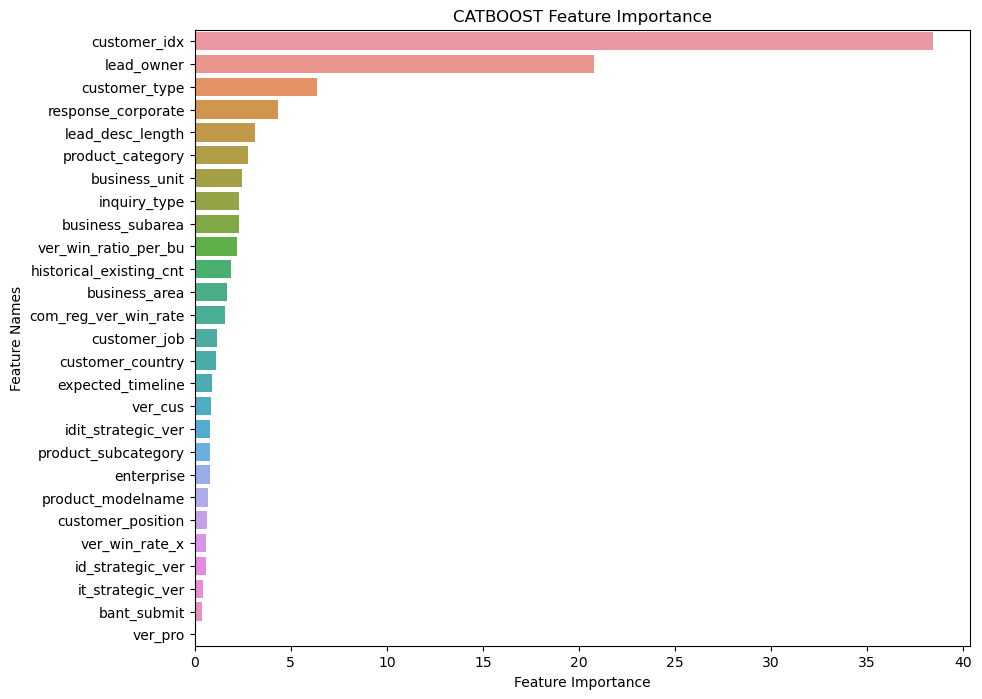

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(best_models[0].get_feature_importance(),df_test.drop(['is_converted','id'],axis=1).columns,'CATBOOST')